# Capstone proposal by Cornelia Blanke

# Time-series analysis and prediction for the HICP dataset of Eurostat<br/> (HICP = Harmonised Index of Consumer Prices)

>**Warning:** I do not have a background in finance or economy but I will do my best about the interpretation of the results.

## 1) The problem

### Explanation of the Consumer Price Index
The **consumer price index** evaluates the price indices for many products and services from an end-consumer point of view. It includes for example price indices for food, energy, mobility, habitation, for services like restaurants or hair-cutter and many more. Its main purpose is the computation of the national inflation rate but it also serves for evaluating further economic or social statistics.

The evaluation is done on a national level but there are some common standards.

In order to quickly understand how this works it is helpful to open Switzerland's data (`su-e-05.02.68.xlsx` from https://www.bfs.admin.ch/bfs/de/home/statistiken/kataloge-datenbanken/tabellen.assetdetail.15964066.html) with Excel/OpenOffice. There we find not only the data in a well-aranged, formatted style but also some explanations and translations:

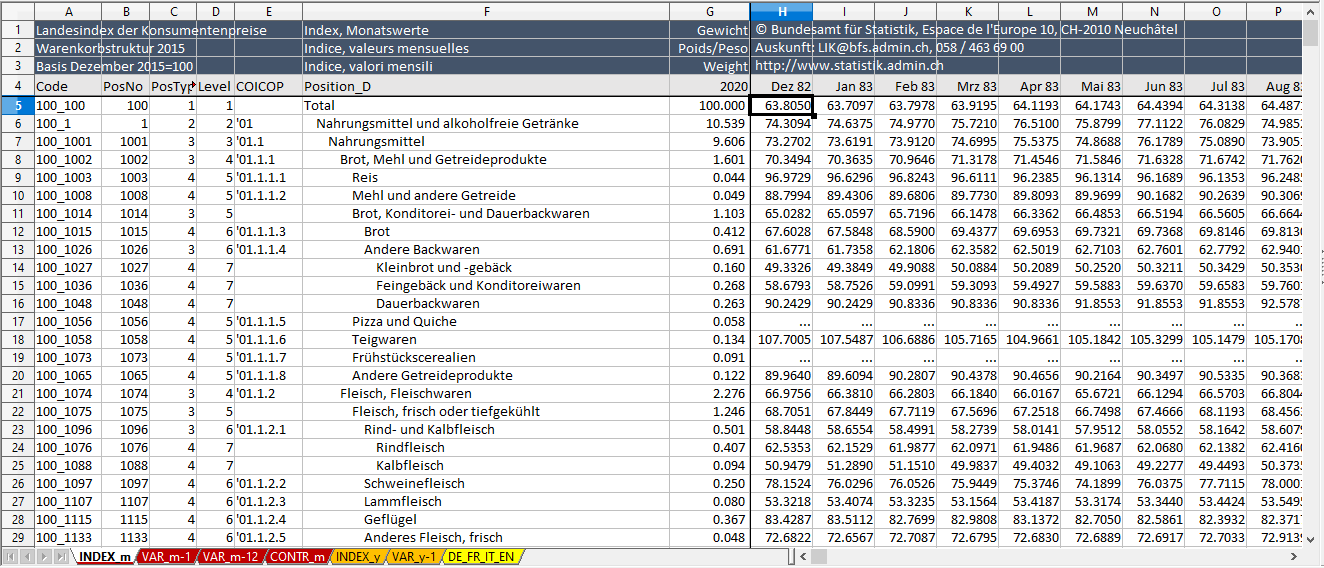

In the first five columns we find several codes for the different product categories. Most important is the COICOP (Classification of Individual Consumption by Purpose) which is an international standard defined by the UN. In the next column we find its explanation in clear text (here only in German, but you find all translations on the tab DE_FR_IT_EN). The product categories are grouped in several hierarchical levels, the lower ones being subcategories of the higher ones. You can also identify the hierarchical level from the column 'Level' and - with some discrepancies in the definition - from the number of digits in the COICOP. The next column specifies the weights and thus the relative importance that this category has on the expenses of the consumer. And then finally we find the monthly data starting from december 1982. The price indices are always given as relative indices with respect to december 2015 = 100%.


The **Statistical Office of the European Union Eurostat** gathers and evaluates the data from its members. Therefore a comparable common standard is used ("harmonisation") that still respects the pecularities of each country. It is slightly different from the national standards (if you want you find more about that point in `953-1800-05.pdf` from https://www.bfs.admin.ch/bfs/en/home/statistics/prices/harmonized-consumer-prices.assetdetail.5266980.html) but the idea is still the same. However, as the price structure and the consumer behaviour are different in different countries, it is important to note that the weights depend on the country and are readjusted on a yearly basis.

The data starts from january 1996 and is not limited to the EU but also includes the EFTA countries (including Switzerland), some EU candidates and the USA. We can download the data here: https://ec.europa.eu/eurostat/web/hicp/data/database.
For a first impression we can also play around with the data explorer provided on the webpage. In contrast to the very nice Excel file from Switzerland the download `prc_hicp_midx.tsv.gz` is unformatted and contains more data than we actually need:

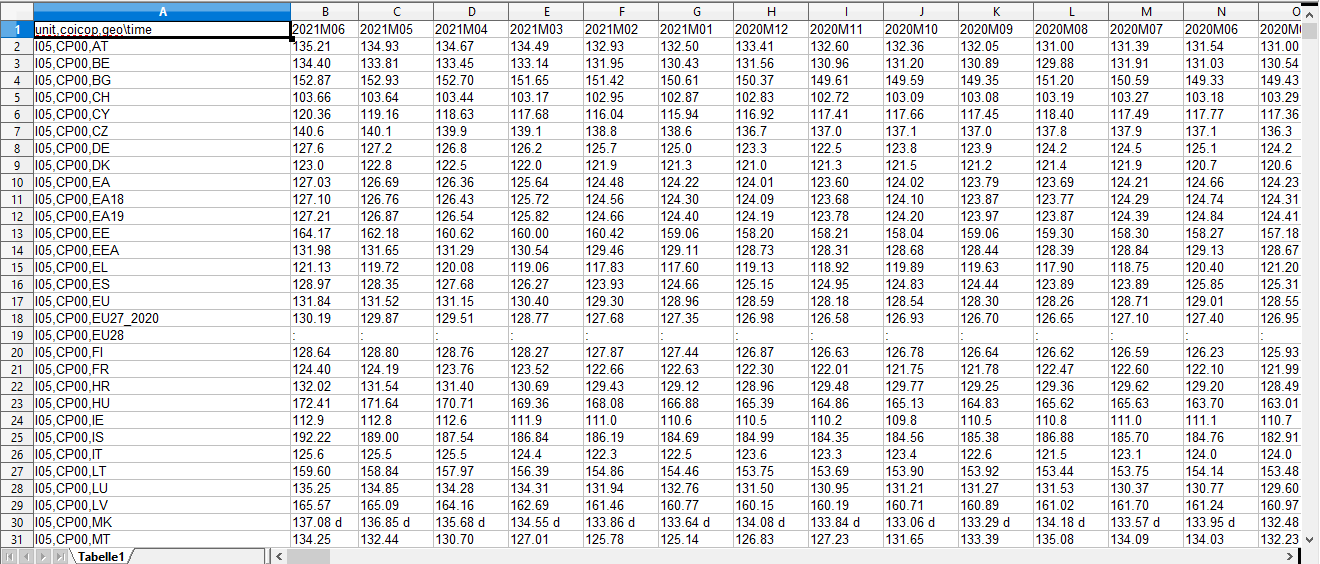

In the first column we find information about the unit (we only need I15, which is the data related to 2015=100%), the COICOP, and the country. In the other columns we find the actual data. There is missing data - especially in the first years - as well as some footnotes/flags that can be looked up on the webpage.

We could have also downloaded the monthly and annually rate of changes but they are provided with only one digit of accuracy. So it is more useful to recompute them by ourselves. But we will also have a look at the weights for the different countries (`prc_hicp_inw.tsv.gz`), so I also downloaded that file.



### Idea of the Capstone Project
As a first step I want to extract and clean up the data that I really need from the file `prc_hicp_midx.tsv.gz`. I want to understand how it works together with the weights file `prc_hicp_inw.tsv.gz`. I would like to find out which countries show a similar behaviour and which are completely different from others. Hopefully I will be able to give some explanations.

I expect every time series to be an overlay of several effects that I would like to make visible:
- overall trend (getting cheaper or more expensive)
- in some cases seasonal fluctuations (winter products, summer products)
- special events (economic crisis, natural disaster, pandemic,...)
- random fluctuations (stock exchange, currencies,...) 

Then I want to ask two **machine learning questions:**
1. **Feature Importance:** Out of several characteristics of the countries (like unemployment rate, population statistics...), which of these have an important impact on the magnitude of the countries' weights?
2. **Regression Problem:** Can we predict the data for one year in advance? What do we need therefore?

## 2) The data

### (a) Clear overview of your data

My goal is to work with the Eurostat's data from `prc_hicp_midx.tsv.gz`:

In [1]:
import pandas as pd
import os
df_midx = pd.read_csv(os.path.join('Prices','Eurostat','prc_hicp_midx.tsv.gz'),sep='\t',compression='gzip')
df_midx.head()

,"unit,coicop,geo\time",2021M06,2021M05,2021M04,2021M03,2021M02,2021M01,2020M12,2020M11,2020M10,...,1996M10,1996M09,1996M08,1996M07,1996M06,1996M05,1996M04,1996M03,1996M02,1996M01
0,"I05,CP00,AT",135.21,134.93,134.67,134.49,132.93,132.50,133.41,132.60,132.36,...,87.29,87.11,87.11,87.38,87.29,87.03,87.11,87.20,86.94,86.68
1,"I05,CP00,BE",134.40,133.81,133.45,133.14,131.95,130.43,131.56,130.96,131.20,...,85.75,85.33,85.16,85.16,85.24,85.41,85.24,84.82,84.65,84.56
2,"I05,CP00,BG",152.87,152.93,152.70,151.65,151.42,150.61,150.37,149.61,149.59,...,:,:,:,:,:,:,:,:,:,:
3,"I05,CP00,CH",103.66,103.64,103.44,103.17,102.95,102.87,102.83,102.72,103.09,...,:,:,:,:,:,:,:,:,:,:
4,"I05,CP00,CY",120.36,119.16,118.63,117.68,116.04,115.94,116.92,117.41,117.66,...,79.90,79.14,77.72,79.01,78.75,78.88,78.65,78.29,75.93,78.32


In addition I want to understand the usage of the weights in `prc_hicp_inw.tsv.gz`:

In [2]:
df_inw = pd.read_csv(os.path.join('Prices','Eurostat','prc_hicp_inw.tsv.gz'),sep='\t',compression='gzip')
df_inw.head()

,"coicop,geo\time",2021,2020,2019,2018,2017,2016,2015,2014,2013,...,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996
0,"AP,AT",91.03,86.32,76.90,75.16,86.11,107.42,105.55,104.87,104.93,...,101.18,99.90,100.04,106.51,122.36,:,:,:,:,:
1,"AP,BE",137.63,139.82,134.23,129.43,132.99,131.44,126.26,112.45,114.47,...,120.93,177.30,173.16,183.44,182.17,:,:,:,:,:
2,"AP,BG",172.51,156.87,155.18,155.94,149.49,155.07,157.18,158.52,175.72,...,188.10,204.97,197.70,190.04,190.32,:,:,:,:,:
3,"AP,CH",303.01,266.18,261.37 e,:,:,273.75,264.70,:,:,...,:,:,:,:,:,:,:,:,:,:
4,"AP,CY",123.27,128.56,107.63,100.92,86.49,84.67,94.66,99.41,103.24,...,77.15,71.68,69.76,71.30,74.82,:,:,:,:,:


From Switzerland's file `su-e-05.02.68.xlsx` I want to extract the decoded English translations of the COICOP codes.
In addition my plan is to keep that file and further downloads as a backup solution in case that I run into serious problems.

### (b) Plan to manage and process the data

I do not expect any erroneous values in the files but they will need some cleaning. The files contain much more data than I actually need. I only need the time-dependent evaluation of the COICOP price indices for all single countries with a reference 2015=100% and the time-dependent weights. All other data can be deleted:

In [3]:
# Restrict study to COICOP with 2015=100%
df_midx = df_midx[df_midx.iloc[:,0].str.contains('I15,CP')]

In [4]:
# Restrict study to single countries

# Delete EA/EA18/EA19 = Euro Area
df_midx = df_midx[~df_midx.iloc[:,0].str.contains(',EA')]
# Delete EU/EU27_2020/EU28 = European Union
df_midx = df_midx[~df_midx.iloc[:,0].str.contains(',EU')]
# Delete EEA = European Economic Area
df_midx = df_midx[~df_midx.iloc[:,0].str.contains(',EEA')]

In [5]:
# Split first column into two and suppress I15
df_midx = pd.concat([df_midx.iloc[:,0].str.split(',',expand=True).iloc[:,1:], df_midx.iloc[:,1:]], axis=1)

In [6]:
dict_countries={'BE':'Belgium', 'BG':'Bulgaria', 'CZ':'Czechia', 'DK':'Denmark', 'DE':'Germany',
                'EE':'Estonia', 'IE':'Ireland', 'EL':'Greece', 'ES':'Spain', 'FR':'France',
                'HR':'Croatia', 'IT':'Italy', 'CY':'Cyprus', 'LV':'Latvia', 'LT':'Lithuania',
                'LU':'Luxembourg', 'HU':'Hungary', 'MT':'Malta', 'NL':'Netherlands', 'AT':'Austria',
                'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 'SI':'Slovenia', 'SK':'Slovakia',
                'FI':'Finland', 'SE':'Sweden', 'IS':'Iceland', 'NO':'Norway', 'CH':'Switzerland',
                'UK':'United Kingdom', 'MK':'North Macedonia', 'RS':'Serbia', 'TR':'Turkey', 'US':'United States'}

df_midx.rename(columns={1:'COICOP', 2:'Country'}, inplace=True)
df_midx.replace(dict_countries, inplace=True)
df_midx.head()

,COICOP,Country,2021M06,2021M05,2021M04,2021M03,2021M02,2021M01,2020M12,2020M11,...,1996M10,1996M09,1996M08,1996M07,1996M06,1996M05,1996M04,1996M03,1996M02,1996M01
7510,CP00,Austria,111.28,111.04,110.83,110.69,109.40,109.05,109.79,109.13,...,71.84,71.69,71.69,71.91,71.84,71.62,71.69,71.77,71.55,71.34
7511,CP00,Belgium,111.11,110.62,110.32,110.07,109.08,107.82,108.76,108.27,...,70.89,70.54,70.40,70.40,70.47,70.61,70.47,70.12,69.98,69.91
7512,CP00,Bulgaria,108.20,108.23,108.08,107.33,107.16,106.59,106.43,105.89,...,:,:,:,:,:,:,:,:,:,:
7513,CP00,Switzerland,101.00,100.99,100.79,100.53,100.32,100.24,100.19,100.09,...,:,:,:,:,:,:,:,:,:,:
7514,CP00,Cyprus,102.17,101.15,100.70,99.89,98.50,98.41,99.24,99.67,...,67.82,67.18,65.97,67.07,66.85,66.96,66.76,66.46,64.45,66.48


In [7]:
print('Number of COICOPs:', df_midx['COICOP'].nunique())
print('Number of Countries:', df_midx['Country'].nunique())

Number of COICOPs: 423
Number of Countries: 35


In [8]:
# Expected number of combinations
423*35

14805

In [9]:
# Actual number of combinations
df_midx.shape[0]

11819

In [10]:
# Restrict study to COICOP
df_inw = df_inw[df_inw.iloc[:,0].str.contains('CP')]

# Delete EA/EA18/EA19 = Euro Area
df_inw = df_inw[~df_inw.iloc[:,0].str.contains(',EA')]
# Delete EU/EU27_2020/EU28 = European Union
df_inw = df_inw[~df_inw.iloc[:,0].str.contains(',EU')]
# Delete EEA = European Economic Area
df_inw = df_inw[~df_inw.iloc[:,0].str.contains(',EEA')]

In [11]:
# Split first column into two
df_inw = pd.concat([df_inw.iloc[:,0].str.split(',',expand=True), df_inw.iloc[:,1:]], axis=1)

# Rename columns
df_inw.rename(columns={0:'COICOP', 1:'Country'}, inplace=True)
df_inw.replace(dict_countries, inplace=True)
df_inw.head()

,COICOP,Country,2021,2020,2019,2018,2017,2016,2015,2014,...,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996
197,CP00,Austria,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
198,CP00,Belgium,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
199,CP00,Bulgaria,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,:
200,CP00,Switzerland,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,:,:,:,:,:,:,:,:,:
201,CP00,Cyprus,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00


In [12]:
# Expected number of combinations
print('Number of COICOPs:', df_inw['COICOP'].nunique())
print('Number of Countries:', df_inw['Country'].nunique())

Number of COICOPs: 423
Number of Countries: 35


In [13]:
# Actual number of combinations
df_inw.shape[0]

13769

We see that the dataset does not include all combinations of COICOP and country. In addition the dataset contains missing values (denoted as ':'). This is because not all product groups or countries have participated in the study from the beginning. There is no reasonable way to fill these fields. So I will keep them as NaN and try to organize my studies around them. 

In [14]:
import numpy as np
df_midx=df_midx.apply(lambda x: x.str.strip())          # Remove whitespaces
df_midx=df_midx.replace(':', np.nan)
df_midx.head()

,COICOP,Country,2021M06,2021M05,2021M04,2021M03,2021M02,2021M01,2020M12,2020M11,...,1996M10,1996M09,1996M08,1996M07,1996M06,1996M05,1996M04,1996M03,1996M02,1996M01
7510,CP00,Austria,111.28,111.04,110.83,110.69,109.40,109.05,109.79,109.13,...,71.84,71.69,71.69,71.91,71.84,71.62,71.69,71.77,71.55,71.34
7511,CP00,Belgium,111.11,110.62,110.32,110.07,109.08,107.82,108.76,108.27,...,70.89,70.54,70.40,70.40,70.47,70.61,70.47,70.12,69.98,69.91
7512,CP00,Bulgaria,108.20,108.23,108.08,107.33,107.16,106.59,106.43,105.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7513,CP00,Switzerland,101.00,100.99,100.79,100.53,100.32,100.24,100.19,100.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7514,CP00,Cyprus,102.17,101.15,100.70,99.89,98.50,98.41,99.24,99.67,...,67.82,67.18,65.97,67.07,66.85,66.96,66.76,66.46,64.45,66.48


In [15]:
df_inw=df_inw.apply(lambda x: x.str.strip())          # Remove whitespaces
df_inw=df_inw.replace(':', np.nan)

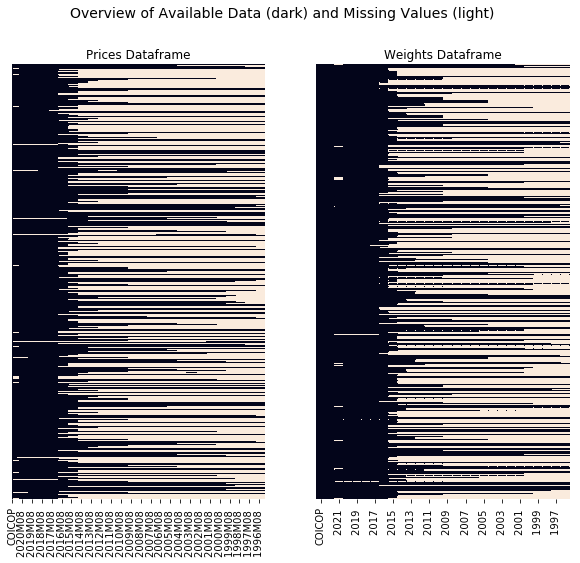

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 8))
fig.suptitle('Overview of Available Data (dark) and Missing Values (light)', fontsize=14)
sns.heatmap(df_midx.isna(), ax=axes[0], yticklabels=False, cbar=False)
axes[0].set_title('Prices Dataframe')
sns.heatmap(df_inw.isna(),  ax=axes[1], yticklabels=False, cbar=False)
axes[1].set_title('Weights Dataframe')
plt.show()

There are also some values marked with flags (e.g. d=definition differs, e=estimated data...). I will store the information about the presence of flags in a separate dataframe and delete the flag from the numerical value. Later I will need to check carefully the consequences and either ignore the flag or the data itself.

In [17]:
def find_flags(text):
    if type(text)==float:       # only if text==NaN
        return np.nan
    if 'b' in text:
        return 'b'
    if 'd' in text:
        return 'd'
    if 'e' in text:
        return 'e'
    if 'r' in text:
        return 'r'
    if 'u' in text:
        return 'u'
    else:
        return ''

In [18]:
# Detect and store all rows with flags
df_midx_flags = pd.concat([df_midx.iloc[:,:2], df_midx.iloc[:,2:].applymap(find_flags)], axis=1)
df_midx_flags.head(20)

,COICOP,Country,2021M06,2021M05,2021M04,2021M03,2021M02,2021M01,2020M12,2020M11,...,1996M10,1996M09,1996M08,1996M07,1996M06,1996M05,1996M04,1996M03,1996M02,1996M01
7510,CP00,Austria,,,,,,,,,...,,,,,,,,,,
7511,CP00,Belgium,,,,,,,,,...,,,,,,,,,,
7512,CP00,Bulgaria,,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7513,CP00,Switzerland,,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7514,CP00,Cyprus,,,,,,,,,...,,,,,,,,,,
7515,CP00,Czechia,,,,,,,,,...,,,,,,,,,,
7516,CP00,Germany,,,,,,,,,...,,,,,,,,,,
7517,CP00,Denmark,,,,,,,,,...,,,,,,,,,,
7521,CP00,Estonia,,,,,,,,,...,,,,,,,,,,
7523,CP00,Greece,,,,,,,,,...,,,,,,,,,,


In [19]:
# Number of rows with flags
df_midx_flags.iloc[:,2:].apply(lambda x: x.str.contains(r'[bderu]',regex=True)).any(axis=1).sum()

3292

In [20]:
# Delete flag from dataframe
df_midx.iloc[:,2:] = df_midx.iloc[:,2:].replace(r'[bderu\s]+', '', regex=True)

In [21]:
# Detect and store all rows with flags
df_inw_flags = pd.concat([df_inw.iloc[:,:2], df_inw.iloc[:,2:].applymap(find_flags)], axis=1)

In [22]:
# Number of rows with flags
df_inw_flags.iloc[:,2:].apply(lambda x: x.str.contains(r'[bderu]',regex=True)).any(axis=1).sum()

1126

In [23]:
# Delete flag from dataframe
df_inw.iloc[:,2:] = df_inw.iloc[:,2:].replace(r'[bderu\s]+', '', regex=True)

Currently the numerical values are interpreted as strings. I need to transform them to floats.

In [24]:
df_midx = df_midx.apply(pd.to_numeric, errors='ignore')
df_midx.dtypes.head(10)

COICOP       object
Country      object
2021M06     float64
2021M05     float64
2021M04     float64
2021M03     float64
2021M02     float64
2021M01     float64
2020M12     float64
2020M11     float64
dtype: object

In [25]:
df_inw = df_inw.apply(pd.to_numeric, errors='ignore')
df_inw.dtypes.head(10)

COICOP      object
Country     object
2021       float64
2020       float64
2019       float64
2018       float64
2017       float64
2016       float64
2015       float64
2014       float64
dtype: object

The dates are given as strings with an additional whitespace:

In [26]:
df_midx.columns

Index(['COICOP', 'Country', '2021M06 ', '2021M05 ', '2021M04 ', '2021M03 ',
       '2021M02 ', '2021M01 ', '2020M12 ', '2020M11 ',
       ...
       '1996M10 ', '1996M09 ', '1996M08 ', '1996M07 ', '1996M06 ', '1996M05 ',
       '1996M04 ', '1996M03 ', '1996M02 ', '1996M01 '],
      dtype='object', length=308)

In [27]:
# Delete whitespace
df_midx.columns = df_midx.columns.str.strip()
df_midx_flags.columns = df_midx_flags.columns.str.strip()
df_midx.columns

Index(['COICOP', 'Country', '2021M06', '2021M05', '2021M04', '2021M03',
       '2021M02', '2021M01', '2020M12', '2020M11',
       ...
       '1996M10', '1996M09', '1996M08', '1996M07', '1996M06', '1996M05',
       '1996M04', '1996M03', '1996M02', '1996M01'],
      dtype='object', length=308)

In [28]:
df_inw.columns = df_inw.columns.str.strip()
df_inw_flags.columns = df_inw_flags.columns.str.strip()
df_inw.columns

Index(['COICOP', 'Country', '2021', '2020', '2019', '2018', '2017', '2016',
       '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007',
       '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998',
       '1997', '1996'],
      dtype='object')

We cannot transform the `Index` to a `DatetimeIndex` as it also includes other data types. So let's keep it as it is and create an additional `DatetimeIndex` (useful for plotting and evaluations):

In [29]:
df_midx_dates = pd.to_datetime(df_midx.columns[2:], format ='%YM%m')
df_midx_dates

DatetimeIndex(['2021-06-01', '2021-05-01', '2021-04-01', '2021-03-01',
               '2021-02-01', '2021-01-01', '2020-12-01', '2020-11-01',
               '2020-10-01', '2020-09-01',
               ...
               '1996-10-01', '1996-09-01', '1996-08-01', '1996-07-01',
               '1996-06-01', '1996-05-01', '1996-04-01', '1996-03-01',
               '1996-02-01', '1996-01-01'],
              dtype='datetime64[ns]', length=306, freq=None)

In [30]:
df_inw_dates = pd.to_datetime(df_inw.columns[2:], format ='%Y')
df_inw_dates

DatetimeIndex(['2021-01-01', '2020-01-01', '2019-01-01', '2018-01-01',
               '2017-01-01', '2016-01-01', '2015-01-01', '2014-01-01',
               '2013-01-01', '2012-01-01', '2011-01-01', '2010-01-01',
               '2009-01-01', '2008-01-01', '2007-01-01', '2006-01-01',
               '2005-01-01', '2004-01-01', '2003-01-01', '2002-01-01',
               '2001-01-01', '2000-01-01', '1999-01-01', '1998-01-01',
               '1997-01-01', '1996-01-01'],
              dtype='datetime64[ns]', freq=None)

My final plan is to add two additional columns to `df_midx`:
- the main product category (1-12) that can be extracted from the COICOP
- the translation into plain English given in Switzerland's Excel file

Then I plan to extract two types of **dataframe:**
- A **small one** containing only the time series of the 12 main categories of all countries (no subcategories):
    - 01 Food
    - 02 Alcohol and tobacco
    - 03 Clothing
    - 04 Housing
    - 05 Household equipment
    - 06 Health
    - 07 Transport
    - 08 Communication
    - 09 Recreation and culture
    - 10 Education
    - 11 Hotels and restaurants
    - 12 Miscellaneous
- A **detailed one** containing the deepest level available so that their weights sum up to 100%: I do not yet know the length of this dataframe but it will be much more than 12 and less than 423, which is the number of listed COICOPs, times the number of countries which is 35.

## 3) Exploratory data analysis (EDA)

### (a) Preliminary EDA

**Understand the weights dataset**

Before analyzing the time series I want to have a deeper look on the weights dataset. Here I will only look at the weights of the 12 main categories. The analysis of all weights will follow in the project itself.

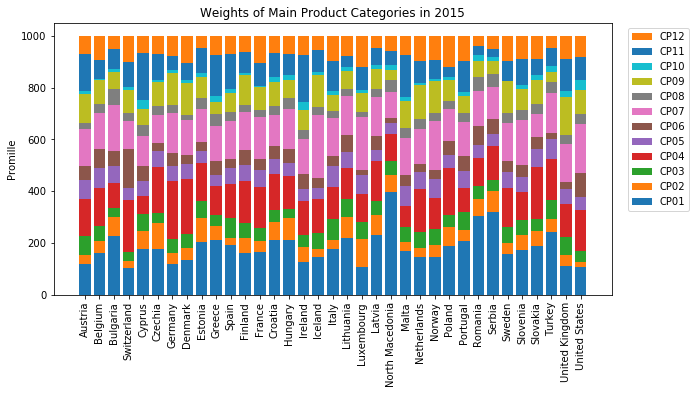

In [31]:
main_cat = ['CP01','CP02','CP03','CP04','CP05','CP06','CP07','CP08','CP09','CP10','CP11','CP12']

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
bottom_val = np.zeros(35)
for cat in main_cat:
    df=df_inw[df_inw['COICOP']==cat]
    plt.bar(np.arange(35), df['2015'], bottom=bottom_val, label=cat)
    bottom_val += df['2015'].values

handles, labels = ax.get_legend_handles_labels()       # found on stackoverflow
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.02, 1))
plt.xticks(np.arange(35), df['Country'], rotation=90)
plt.ylabel('Promille')
plt.title('Weights of Main Product Categories in 2015')
plt.show()

As expected we see that the weights of the main categories in 2015 sum up to 100% (=1000 promille). The same is also true for all other years: 

In [32]:
Countries = df_inw['Country'].unique()
for country in Countries:
    sum=np.zeros(len(df_inw.columns[2:]))
    for cat in main_cat:
        sum += df_inw.loc[(df_inw['Country']==country) & (df_inw['COICOP']==cat),:].iloc[:,2:].values[0]
    print('{:15}: min {:7.2f} | max {:7.2f} | nan {:2}'.format(country, np.nanmin(sum), np.nanmax(sum), np.isnan(sum).sum()))

Austria        : min  999.99 | max 1000.02 | nan  0
Belgium        : min  999.98 | max 1000.02 | nan  0
Bulgaria       : min  999.98 | max 1000.02 | nan  1
Switzerland    : min 1000.00 | max 1000.00 | nan  9
Cyprus         : min  999.97 | max 1000.01 | nan  0
Czechia        : min  999.98 | max 1000.02 | nan  0
Germany        : min 1000.00 | max 1000.00 | nan  0
Denmark        : min  999.98 | max 1000.02 | nan  0
Estonia        : min  999.98 | max 1000.01 | nan  0
Greece         : min  999.98 | max 1000.03 | nan  1
Spain          : min  999.93 | max 1000.02 | nan  0
Finland        : min  999.97 | max 1000.03 | nan  0
France         : min  999.98 | max 1000.02 | nan  0
Croatia        : min 1000.00 | max 1000.00 | nan  2
Hungary        : min 1000.00 | max 1000.00 | nan  0
Ireland        : min  999.98 | max 1000.02 | nan  0
Iceland        : min  999.99 | max 1000.02 | nan  0
Italy          : min  999.99 | max 1000.04 | nan  0
Lithuania      : min  999.98 | max 1000.02 | nan  0
Luxembourg  

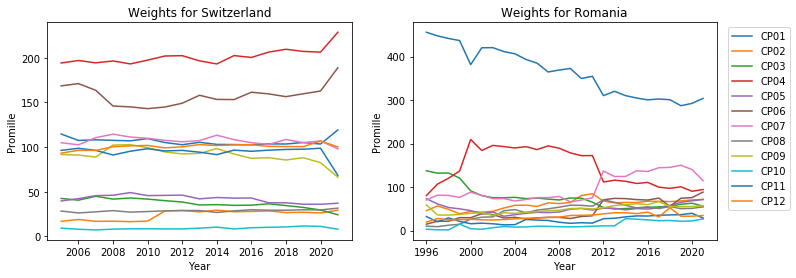

In [33]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for cat in main_cat:
    axes[0].plot(df_inw_dates,
             df_inw.loc[(df_inw['Country']=='Switzerland') & (df_inw['COICOP']==cat),:].iloc[:,2:].values[0])
    axes[0].set_title('Weights for Switzerland')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Promille')
    
    axes[1].plot(df_inw_dates,
             df_inw.loc[(df_inw['Country']=='Romania') & (df_inw['COICOP']==cat),:].iloc[:,2:].values[0])
    axes[1].set_title('Weights for Romania')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Promille')
plt.legend(main_cat, loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

For some countries (e.g. Switzerland, same for Germany) the weights do not change a lot over time. Note that Switzerland's weights are only given from 2005 onwards. For some others (e.g. Romania) there are significant changes over time. We can also see that the order of the weights, i.e. the importance of the main product categories, is completely different for those two countries.

It is not straightforward how the weights have to be used in conjunction with the price indices. A short description is found on https://ec.europa.eu/eurostat/statistics-explained/index.php?title=HICP_methodology and all the details and formulas are found in chapter 8 of `KS-GQ-17-015-EN-N.pdf`. In short, if one wants to compute the next-higher index out of the lower ones there are the following steps:
- Unchain the indices: The continuous lower-level indices over all years are broken into segments that are defined as relative values to the index value in december of the previous year.
- Compute the weighted sum out of the unchained indices: Thereby the weights are dependent from the year.
- Chain-link those sum: The chained index is computed by starting at a certain point and then connecting one-by-one all the subsequent segments by multiplying them with the index value of the previous december.

I want to try out if I have understood the principle. Let's try to recompute the total index CP00 out of the indices of the main categories and their weights: 

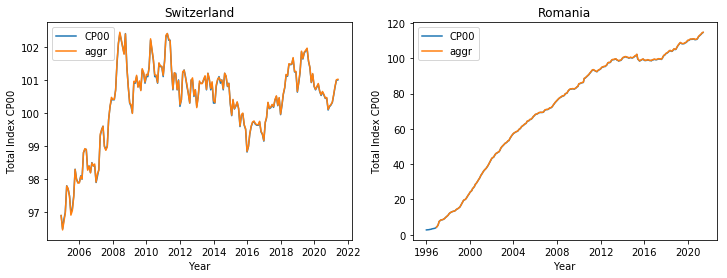

In [34]:
from datetime import datetime

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for country in ['Switzerland','Romania']:
    # initialize variables
    aggr = np.zeros(len(df_midx.columns[2:]))
    mindate_CPXX = pd.to_datetime('1900', format ='%Y')
    
    # earliest available date in CP00
    mindate_CP00 = min(df_midx_dates[
        ~df_midx[(df_midx['Country']==country) & (df_midx['COICOP']=='CP00')].iloc[:,2:].isna().values[0]])    
    
    
    for cat in main_cat:
        # unchain (not defined for first year!)
        unchain = df_midx[(df_midx['Country']==country) & (df_midx['COICOP']==cat)].iloc[:,2:].values[0] \
            / np.concatenate([df_midx.loc[(df_midx['Country']==country) & (df_midx['COICOP']==cat), 
                          (df_midx_dates[:-12].year-1).astype('str')+'M12'].values[0], [np.nan]*12 ]) * 100
        
        
        # aggregate
        aggr+= df_inw.loc[(df_inw['Country']==country) & (df_inw['COICOP']==cat), df_midx_dates.year.astype('str')].values[0] \
                * unchain / 1000
        # save earliest available date for all CPXX
        mindate_CPXX = max(min(df_midx_dates[~np.isnan(aggr)]), mindate_CPXX)

    
    # determine starting date for chain-linking    
    if mindate_CPXX > mindate_CP00:
        # if january --> take december previous year
        if mindate_CPXX.month == 1:
            mindate_CP00 = datetime(year=mindate_CPXX.year-1, month=12, day=1)
        # else --> take december that year
        else:
            mindate_CP00 = datetime(year=mindate_CPXX.year, month=12, day=1)
            
    # chain-linking the aggregates
    aggr[df_midx_dates < mindate_CP00] = np.nan
    aggr[df_midx_dates == mindate_CP00] = df_midx.loc[(df_midx['Country']==country) & (df_midx['COICOP']=='CP00'), 
                                                      str(mindate_CP00.year)+'M12'].values[0]
    
    for sampleyear in np.arange(mindate_CP00.year+1, max(df_midx_dates.year)+1):
        aggr[df_midx_dates.year == sampleyear] *= aggr[df_midx_dates == datetime(year=sampleyear-1, month=12, day=1)]/100
        
        
    # create plot
    axes[int(country=='Romania')].plot(df_midx_dates,
             df_midx[(df_midx['Country']==country) & (df_midx['COICOP']=='CP00')].iloc[:,2:].values[0])
    axes[int(country=='Romania')].plot(df_midx_dates, aggr)
    axes[int(country=='Romania')].set_title(country)
    axes[int(country=='Romania')].set_xlabel('Year')
    axes[int(country=='Romania')].set_ylabel('Total Index CP00')
    axes[int(country=='Romania')].legend(['CP00','aggr'])

We see that I get a very good agreement and that's fine!

**Overview of the time series**

As the next step I want to get an overview of the time series. Of course I cannot have a detailed look at every single time series but I want to figure out at least some characteristics about the different product categories and/or the countries.

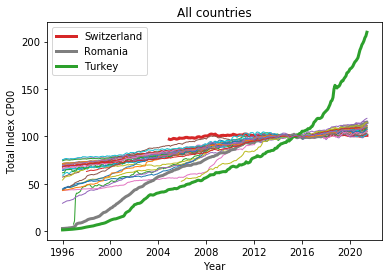

In [35]:
for country in Countries:
    if country in ['Switzerland','Romania','Turkey']:
        plt.plot(df_midx_dates,
             df_midx[(df_midx['Country']==country) & (df_midx['COICOP']=='CP00')].iloc[:,2:].values[0],
            linewidth=3, label=country)
        plt.legend()
    else:
        plt.plot(df_midx_dates,
             df_midx[(df_midx['Country']==country) & (df_midx['COICOP']=='CP00')].iloc[:,2:].values[0],
            linewidth=1)
plt.title('All countries')
plt.xlabel('Year')
plt.ylabel('Total Index CP00')
plt.show()

For the total index CP00 a lot of countries lie in a narrow band but some others are clearly different. In the plot I have highlighted Switzerland, Romania and Turkey. We can also visually confirm that all time series are passing through 100 in year 2015.

Next, I will do the same for the main categories 1-12:

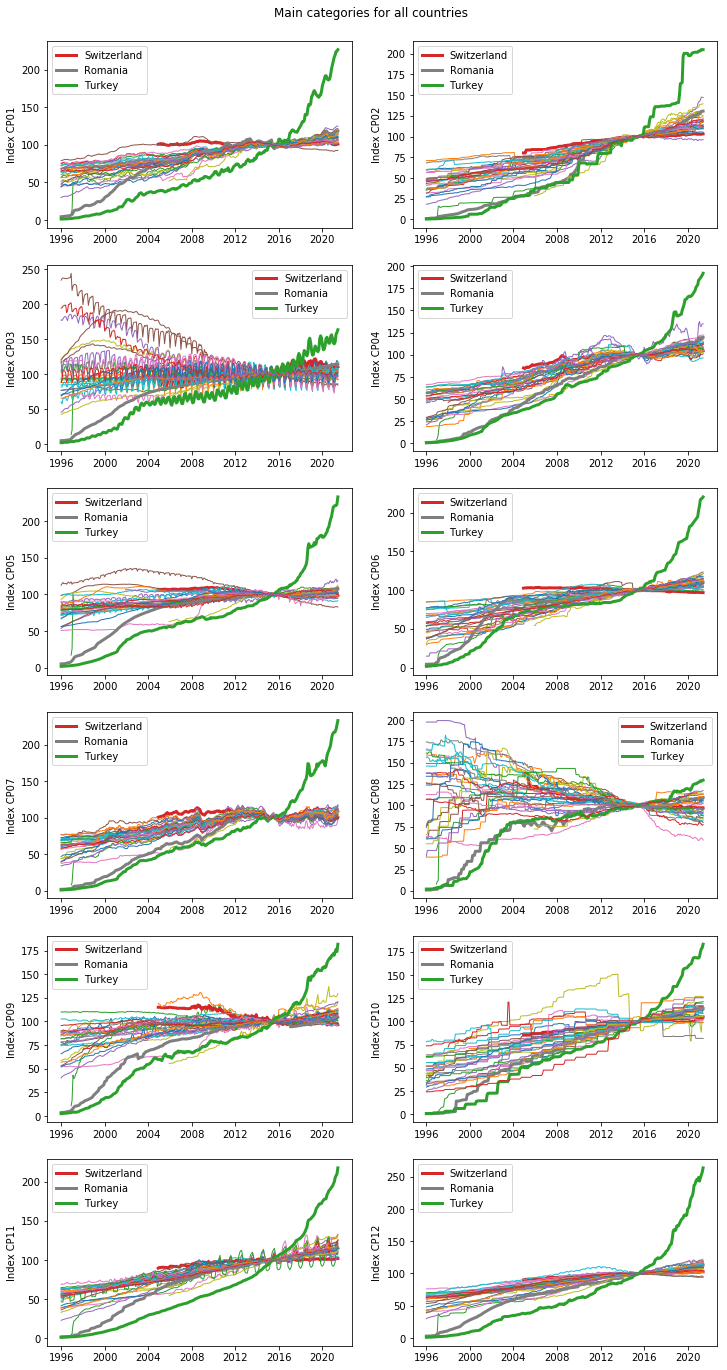

In [36]:
fig, axes = plt.subplots(6, 2, figsize=(12, 24))

for cat, ax in zip(main_cat, axes.ravel()):
    for country in Countries:
        if country in ['Switzerland','Romania','Turkey']:
            ax.plot(df_midx_dates,
                 df_midx[(df_midx['Country']==country) & (df_midx['COICOP']==cat)].iloc[:,2:].values[0],
                linewidth=3, label=country)
            ax.legend()
        else:
            ax.plot(df_midx_dates,
                 df_midx[(df_midx['Country']==country) & (df_midx['COICOP']==cat)].iloc[:,2:].values[0],
                linewidth=1)
    ax.set_ylabel('Index '+cat)
fig.suptitle('Main categories for all countries', y=0.9)
plt.show()

Some of the plots look similar to the plot of the total index CP00 but some others are significantly different:
- For CP03 ("Clothing") and also for some countries in CP11 ("Hotels and restaurants") we see seasonal fluctuations.
- For CP08 ("Communication") we notice a very wide spread and for many countries decreasing indices.
- For CP10 ("Education") we see stepwise changes for several countries. That can be explained by educational expenses being constant throughout the school year.

Let's again compare Switzerland and Romania:

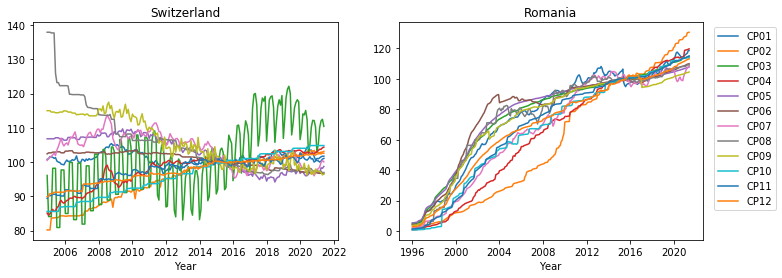

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for country in ['Switzerland','Romania']:
    for cat in main_cat:
        axes[int(country=='Romania')].plot(df_midx_dates,
             df_midx[(df_midx['Country']==country) & (df_midx['COICOP']==cat)].iloc[:,2:].values[0])
    axes[int(country=='Romania')].set_title(country)
    axes[int(country=='Romania')].set_xlabel('Year')
plt.legend(main_cat, loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

Let's look if there are some flags:

In [38]:
with pd.option_context('display.max_columns', None):
    display(df_midx_flags[(df_midx_flags['Country'].isin(['Switzerland','Romania'])) 
                          & (df_midx_flags['COICOP'].isin(main_cat))
              & (~df_midx_flags.iloc[:,2:].isin(['',np.nan]).all(axis=1))])

,COICOP,Country,2021M06,2021M05,2021M04,2021M03,2021M02,2021M01,2020M12,2020M11,2020M10,2020M09,2020M08,2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,2020M01,2019M12,2019M11,2019M10,2019M09,2019M08,2019M07,2019M06,2019M05,2019M04,2019M03,2019M02,2019M01,2018M12,2018M11,2018M10,2018M09,2018M08,2018M07,2018M06,2018M05,2018M04,2018M03,2018M02,2018M01,2017M12,2017M11,2017M10,2017M09,2017M08,2017M07,2017M06,2017M05,2017M04,2017M03,2017M02,2017M01,2016M12,2016M11,2016M10,2016M09,2016M08,2016M07,2016M06,2016M05,2016M04,2016M03,2016M02,2016M01,2015M12,2015M11,2015M10,2015M09,2015M08,2015M07,2015M06,2015M05,2015M04,2015M03,2015M02,2015M01,2014M12,2014M11,2014M10,2014M09,2014M08,2014M07,2014M06,2014M05,2014M04,2014M03,2014M02,2014M01,2013M12,2013M11,2013M10,2013M09,2013M08,2013M07,2013M06,2013M05,2013M04,2013M03,2013M02,2013M01,2012M12,2012M11,2012M10,2012M09,2012M08,2012M07,2012M06,2012M05,2012M04,2012M03,2012M02,2012M01,2011M12,2011M11,2011M10,2011M09,2011M08,2011M07,2011M06,2011M05,2011M04,2011M03,2011M02,2011M01,2010M12,2010M11,2010M10,2010M09,2010M08,2010M07,2010M06,2010M05,2010M04,2010M03,2010M02,2010M01,2009M12,2009M11,2009M10,2009M09,2009M08,2009M07,2009M06,2009M05,2009M04,2009M03,2009M02,2009M01,2008M12,2008M11,2008M10,2008M09,2008M08,2008M07,2008M06,2008M05,2008M04,2008M03,2008M02,2008M01,2007M12,2007M11,2007M10,2007M09,2007M08,2007M07,2007M06,2007M05,2007M04,2007M03,2007M02,2007M01,2006M12,2006M11,2006M10,2006M09,2006M08,2006M07,2006M06,2006M05,2006M04,2006M03,2006M02,2006M01,2005M12,2005M11,2005M10,2005M09,2005M08,2005M07,2005M06,2005M05,2005M04,2005M03,2005M02,2005M01,2004M12,2004M11,2004M10,2004M09,2004M08,2004M07,2004M06,2004M05,2004M04,2004M03,2004M02,2004M01,2003M12,2003M11,2003M10,2003M09,2003M08,2003M07,2003M06,2003M05,2003M04,2003M03,2003M02,2003M01,2002M12,2002M11,2002M10,2002M09,2002M08,2002M07,2002M06,2002M05,2002M04,2002M03,2002M02,2002M01,2001M12,2001M11,2001M10,2001M09,2001M08,2001M07,2001M06,2001M05,2001M04,2001M03,2001M02,2001M01,2000M12,2000M11,2000M10,2000M09,2000M08,2000M07,2000M06,2000M05,2000M04,2000M03,2000M02,2000M01,1999M12,1999M11,1999M10,1999M09,1999M08,1999M07,1999M06,1999M05,1999M04,1999M03,1999M02,1999M01,1998M12,1998M11,1998M10,1998M09,1998M08,1998M07,1998M06,1998M05,1998M04,1998M03,1998M02,1998M01,1997M12,1997M11,1997M10,1997M09,1997M08,1997M07,1997M06,1997M05,1997M04,1997M03,1997M02,1997M01,1996M12,1996M11,1996M10,1996M09,1996M08,1996M07,1996M06,1996M05,1996M04,1996M03,1996M02,1996M01
11039,CP03,Romania,,,,,,,,,,,,,,,u,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17482,CP09,Switzerland,,,,,,,,,,,,,,,u,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20066,CP10,Romania,,,,,,,,,,,,,,u,u,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20290,CP11,Switzerland,,,u,u,u,u,,,,,,,,,u,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,NaN,N

We find some flags for both countries in 2020/2021. If we look up the flag 'u' we see that it means "low reliability due to covid-19" - that makes sense. 

### (b) How does the EDA inform your project plan?

The preliminary EDA showed that there are some differences in between the countries. This is true for the weights as well as for the time series. But in the same time there are as well several countries that show a very similar behaviour. We have also seen that the time series of some product categories show specific characteristics like seasonality or stepwise increases. It will be interesting to see how that looks like for the sub-categories.

For both machine learning tasks the EDA also informs in which cases I have sufficient useful data. As machine learning cannot deal with missing values I need to restrict my studies to a sub-dataset that fulfills this request. So either I have to exclude certain countries from the model or I have to restrict the model to a shorter time range. 

**Machine Learning Task 1:**

In machine learning task 1 I will have a deeper look on the weights dataset of the main product categories 1-12. In addition I will collect several characteristics about the countries. The EDA will give me some insights into the weights dataset and about similarities in between countries.
 

**Machine Learning Task 2:**

For machine learning task 2 I want to focus on the small dataframe with all countries and only the main product categories. At the moment I think about using year 2019 as the test set as this was the last "usual" year before covid-19. I fear that 2020 shows effects that cannot be predicted although Eurostat did some covid-19 corrections.

The EDA will inform me how the trends look like and if there might be special pitfalls in some cases. It might also be helpful to base the model not on the HICP price indices dataset but on their rate of changes. We could also try to use the data smoothed by rolling windows instead of the original one and thus neglect the random fluctuations.

### (c) What further EDA do you plan for project?

**Data Preparation**

Until now and especially in part (a) I have focussed on the full dataset and on the main product categories. I still need to extract the detailed dataframe. Both dataframes - the small and the detailed one - need to be saved to separate pandas variables. I want to add a column indicating the main product categories of all products as an integer 1-12 and another column giving the product names in plain text. That will make evaluations and interpretations much easier and comfortable.

**Analysis of the weights**

The analysis of the weights complements machine learning task 1. It might be interesting to see how the weights depend from the country, if there are big differences between the countries and how they change over time. Does that accord with my natural gut feeling?

In part (a) we got some first impressions of the weights of the main product categories but I only checked for consistency in the dataset and did not do any interpretation. So after doing the same consistency checks for the detailed dataframe I will do some more EDA like sorting the countries, computing means, finding outliers and so on. Maybe we can prove or disprove some of the prejudices about the countries like "Italians eat a lot of pasta", "Germans love their cars" and so on.

**Time series analysis**

I will do some more time series plots for the detailed dataframe in order to see if the plots for the sub-categories show similar patterns as for the main product categories.

**Compute and analyze the monthly rate of changes**

It is also helpful to compute the monthly rate of change of the prices. That will give insights into inflation rates, products getting cheaper or more expensive over time, stable or rougher market times, sudden chocks etc. 

Again a big part of this analysis will be done by creating plots of the data over time but we can also do some comparative descriptive statistics.

**Try out the rolling window method**

Then I want to try out the "rolling windows method" that we learnt in the course for some of those time series. This method should smooth out the random effects while maintaining global and seasonal patterns.

**Find price indices showing seasonality**

Finally I want to find out which time series show a seasonality pattern. Therefore I will shift all time series by 12 months and compute the correlation between the original and the shifted series (or its monthly rate of change). If there is a strong correlation this is an indicator for seasonality. We can repeat the study for a shift of 24, 36, 48, ... months to verify our findings.

In case I do not find any product groups showing seasonality in the HICP database I could use the "Fruits and Vegetables" category from Switzerland's database.

## 4) Machine learning 

### (a) Phrase your project goal as a clear machine learning question

**Machine Learning Task 1:**

In machine learning task 1 I want to understand the differences for the countries in the weights dataset. Therefore I will collect characteristic data about the countries and their people (e.g. unemployment rate, population statistics, living and housing standards, traffic...).

Then I want to make use of machine learning technologies in order to judge about the importance of those characteristics (= the features). As the dataset is rather small it is not the goal to learn an optimal model and to test its performance but to use the ML algorithms to find out what is important and what isn't.

So my question is: For each of the main product categories 1-12, which characteristics (= features) have the strongest impact on the weights dataset? 


 

**Machine Learning Task 2:**

For machine learning task 2 I want to focus on the small dataframe with all countries and only the main product categories. I want to fit a model that is able to predict the time series of 2019 from the previous years. As already said I think about using year 2019 as the test set as this was the last "usual" year before covid-19. I fear that 2020 shows effects that cannot be predicted although Eurostat did some covid-19 corrections.

In the first steps I plan to predict each single time series out of its past. Then I want to compare this outcome to a model where I predict in one step all time series in 2019 out of the history of all time series.

### (b) What models are you planning to use and why?

**Machine Learning Task 1:**

*Principal Component Analysis:*

First I want to perform a principal component analysis on my features as I suspect them to be neither independent nor well-distributed. In fact I assume that several characteristics depend more or less from the richness or poverty of that country. The PCA will give me information about the variance in my features but it still does not tell me which features are important for which weights. It may still be that a feature classified as "not so important" by the PCA is particularly important for the weight of product category X. That is why we still need additional analysis that take into account not only the features but also the targets. 

*Linear Regression Models:*

If all features are scaled to the same range, the coefficients of a linear regression model show the importance of the respective features. We have seen throughout the course that different LR models with or without regularization may give different sets of coefficients. But if we see that certain features are captured as being important by almost all models then we can be sure that they really matter.

*Decision Tree Regressors and Random Forest Regressors:*

A decision tree provides a very intuitive overview of what is the most important decision and thus the most important feature, what is the second and so on. In addition one of its output is the formal `feature_importances_` property that is used internally to build up the tree. The same is true for the random forest regressor. So we can make use of both of these methods to get another idea about the importance of the features.

*Feature permutation in kNN-regressor:*

When preparing the proposal I have read about the `sklearn.inspection.permutation_importance` which is only available from scikit-learn version 0.22 onward. However it inspired me to do something similar by hand:

If I evaluate the accuracy of a kNN model on the dataset it was trained on I will always get a very high (or even 1.0) accuracy. But if I randomly shuffle the values of one of the features and evaluate again the model's prediction I can see if the new accuracy stays approximately the same or if it deteriorates significantly. In the latter case I can conclude that this feature was an important one for the model.



**Machine Learning Task 2:**

This is a regression task, too. As the time series contains a mixture of random and deterministic effects I do not expect very high prediction accuracies. In the course we only had one example about time series prediction that was showing a much more regular pattern (flight passengers over years). So I am excited how good the prediction will work for my case! 

*Scikit-learn models:*

As explained in (a) I want to start slowly and keep it simple in the beginning. So I will start with a linear regression model. As nonlinear models from scikit-learn I would like to try out support vector regression and random forests. Note that for the latter it is better not to work directly on the time series but on the rate of changes because it is not able to extrapolate data outside the range of feature values. When cross-validating the model we need to keep in mind not to use k-fold validation (this will predict the past out of the future!) but forward chaining validation as we have learnt in the course:

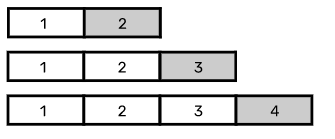

*Tensorflow models:*

Afterwards I want to focus on the models from tensorflow:
https://www.tensorflow.org/tutorials/structured_data/time_series<br/>
Again I want to start slowly with a dense NN with one hidden layer. But then it really sounds interesting to use CNNs for time series (until now, we only used it for image classification!) and to try out a RNN that we did not cover in the course. I found a good tutorial that shows step-by-step how to prepare the data and how to build different kinds of simple 1-dimensional CNNs:
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

### (c) Please tell us your detailed machine learning strategy 

A big difference between ML task 1 and 2 is the setup of the feature matrix `X` and the target vector `y`. In ML task 1 the features are certain characteristics of the countries, the samples are different countries, and the targets are the weights. There are no limitiations how we order the samples.

This is completely different for ML task 2. Now the samples are the time points, and their order has to be kept. The target is the time series and the features are the same time-series but shifted in time. So a value at time point `n` depends on the values at time points `n-1 ,n-2,...`.

For ML task 1 we do not care too much about accuracy as long as the model gives reasonable results. The task is not about optimizing the model performance (therefore the number of samples is too low) but about creating understanding and telling a story.

For ML task 2 accuracy matters, but here it is not so straightforward how to judge about accuracy. It always makes sense to have a visual look by plotting the test data and its prediction but we cannot do that for all available time series. Nevertheless this is the only way I see how we can distinguish which trends or patterns can be captured and where the prediction fails. A numerical evaluation like the MAE is good for comparing global accuracies between various models but it does not provide any details where the error comes from. I see two possible baselines to investigate: (a) linear extrapolation from the previous year (i.e. constant rate of change) or (b) repeating all values from the previous year. 

**Machine Learning Task 1:**

**Step 1: Extract the features and the targets**

As we have already looked at the differences in the weights dataset from 2015 I decided to work again with the data from that year.

The first step is to collect useful data about the countries, their population, their living standards, daily life, education, traffic, crimes... that will serve as features. Therefore I went again over Eurostat's databases https://ec.europa.eu/eurostat/web/main/data/database. This time I did not download the full databases but used the online data explorer to extract what I really need into small Excel files. I kept their cryptic names as proposed by Eurostat as this is the easiest way to find the study again on the website if needed.

Then I created an empty pandas dataframe for only the countries I am interested in and read in one-by-one the data from those Excel files. For some of the values it makes sense to scale them with the total number of inhabitants of that country. Finally I was able to fill some empty values by rough estimations from previous years or neighbouring countries:

In [39]:
# Create empty dataframe with relevant countries
df_task1 = pd.DataFrame(index=np.sort(Countries))

dict = {'Germany (until 1990 former territory of the FRG)':'Germany'}

# Append all information from Excel files

# Averaged unemployment rate
df_task1 = pd.DataFrame(df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ei_lmhr_m.xls'),
                  index_col=0, na_values=':').rename(index=dict)).astype('float').mean(axis=1),
                       columns=['Unemployment rate'])

#Total population
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','demo_pjan.xls'), 
                  names=['','Population'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Proportion of young/old population
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','demo_pjanind.xls'), sheet_name=0, 
                  names=['','Proportion 0-17'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','demo_pjanind.xls'), sheet_name=1, 
                  names=['','Proportion >64'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Immigration
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','migr_imm8.xls'), 
                  names=['','Immigration/1000 inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1['Immigration/1000 inh'] = 1000*df_task1['Immigration/1000 inh']/df_task1['Population']

# Emigration
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','migr_emi2.xls'), 
                  names=['','Emigration/1000 inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1['Emigration/1000 inh'] = 1000*df_task1['Emigration/1000 inh']/df_task1['Population']


# Divorces per 100 marriages
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','demo_ndivind.xls'), 
                  names=['','Divorces/100 marriages'], index_col=0, na_values=':').rename(index=dict)).astype('float')


# Income quintile share ratio S80/S20
# Definition: It is calculated as the ratio of total income received by the 20 % of the population with the highest income
#(the top quintile) to that received by the 20 % of the population with the lowest income (the bottom quintile). 
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_di11.xls'), 
                  names=['','Income quintile share ratio'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Risk of poverty rate
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_peps01n.xls'), 
                  names=['','Risk of poverty rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Proportion of population by health status
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvhl01.xls'), sheet_name=0, 
                  names=['','Very good health'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvhl01.xls'), sheet_name=1, 
                  names=['','Good health'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvhl01.xls'), sheet_name=3, 
                  names=['','Bad health'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvhl01.xls'), sheet_name=4, 
                  names=['','Very bad health'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Proportion of population with household tenure status = owner
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvho02.xls'), 
                  names=['','Household owner rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Proportion of population with single person household
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvho02b.xls'), 
                  names=['','Single household rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Proportion of young adults 18-34 living with their parents
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvps08.xls'), 
                  names=['','Young adults living with parents'], 
                  index_col=0, na_values=':').rename(index=dict)).astype('float')

# Proportion of population by education level
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvps04.xls'), sheet_name=0, 
                  names=['','Low education rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_lvps04.xls'), sheet_name=1, 
                  names=['','High education rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Children in no formal childcare
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','ilc_caindformal.xls'), 
                  names=['','No childcare rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Rail passengers
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','rail_pa_total.xls'), 
                  names=['','Rail passengers/inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1['Rail passengers/inh'] = 1000*df_task1['Rail passengers/inh']/df_task1['Population']

# Passenger cars by age
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','road_eqs_carage.xls'), sheet_name=0, 
                  names=['','Cars/100 inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','road_eqs_carage.xls'), sheet_name=1, 
                  names=['','Young cars rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1['Young cars rate'] = 100*df_task1['Young cars rate']/df_task1['Cars/100 inh']
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','road_eqs_carage.xls'), sheet_name=2, 
                  names=['','Old cars rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1['Old cars rate'] = 100*df_task1['Old cars rate']/df_task1['Cars/100 inh']
df_task1['Cars/100 inh'] = 100*df_task1['Cars/100 inh']/df_task1['Population']

# Persons killed in road accidents
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','tran_sf_roadse.xls'), 
                  names=['','Killed in road acc/mio inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1['Killed in road acc/mio inh'] = 1e6*df_task1['Killed in road acc/mio inh']/df_task1['Population']

# Participation in tourism for personal purpose
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','tour_dem_totot.xls'), 
                  names=['','Participation in tourism rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Rate of internet access in households
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','isoc_ci_in_h.xls'), 
                  names=['','Internet access rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# EPO patent applications
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','pat_ep_ntot.xls'), 
                  names=['','Patents/mio inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Recycling rate of waste
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','env_waspacr.xls'), 
                  names=['','Recycling rate'], index_col=0, na_values=':').rename(index=dict)).astype('float')

# Crime data
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','crim_off_cat.xls'), sheet_name=0, 
                  names=['','Homicides/100000 inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','crim_off_cat.xls'), sheet_name=1, 
                  names=['','Sexual violence/100000 inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')
df_task1 = df_task1.join(
    pd.read_excel(os.path.join('Prices','Eurostat','crim_off_cat.xls'), sheet_name=2, 
                  names=['','Thefts/100000 inh'], index_col=0, na_values=':').rename(index=dict)).astype('float')


# Fill some missing values by hand

# mean of England, Scotland, Northern Ireland:
df_task1.loc['United Kingdom',
             ['Homicides/100000 inh','Sexual violence/100000 inh','Thefts/100000 inh']] = [1.12, 172, 1789]
# no rail system
df_task1.loc[['Cyprus','Iceland','Malta'], 'Rail passengers/inh'] = [0, 0, 0]
# use values from 2014
df_task1.loc[['Switzerland','Turkey'], 'No childcare rate'] = [34, 88]    #Turkey from 2009
df_task1.loc[['Iceland','Switzerland'], 'Internet access rate'] = [96, 91]
df_task1.loc[['Iceland','Norway','Switzerland','Turkey','United States'],
             'Patents/mio inh'] = [97.74, 95.73, 398.67, 6.31, 115.74]
# rough extrapolation
df_task1.loc[['Belgium','Hungary','Netherlands'],'Rail passengers/inh'] = \
    [250, 146, 450]/df_task1.loc[['Belgium','Hungary','Netherlands'],'Population']*1e6
df_task1.loc['Iceland', 'Divorces/100 marriages'] = 35
# other sources
df_task1.loc['Iceland', 'Cars/100 inh'] = 226000/(df_task1.loc['Iceland','Population']/100)
# no information, guess from neighboring countries
df_task1.loc['Iceland', 'Participation in tourism rate'] = 70
df_task1.loc['Switzerland', 'Recycling rate'] = 68


df_task1

,Unemployment rate,Population,Proportion 0-17,Proportion >64,Immigration/1000 inh,Emigration/1000 inh,Divorces/100 marriages,Income quintile share ratio,Risk of poverty rate,Very good health,...,Young cars rate,Old cars rate,Killed in road acc/mio inh,Participation in tourism rate,Internet access rate,Patents/mio inh,Recycling rate,Homicides/100000 inh,Sexual violence/100000 inh,Thefts/100000 inh
Austria,6.150000,8584926.0,17.4,18.5,19.373842,6.603318,36.7,4.05,16.9,31.1,...,17.522569,28.088469,55.795472,58.78,82.0,233.15,67.1,0.49,40.57,1635.37
Belgium,8.500000,11237274.0,20.3,18.1,13.048182,7.990728,54.8,3.83,21.6,28.8,...,20.912038,21.205001,67.810040,48.98,82.0,139.69,81.5,2.06,61.30,2196.73
Bulgaria,9.150000,7202198.0,16.4,20.0,3.502125,4.091806,37.8,7.11,43.4,17.6,...,NaN,NaN,98.303324,21.57,59.0,4.43,64.1,1.75,8.37,531.99
Croatia,16.133333,4225316.0,18.1,18.8,2.770444,7.017463,30.3,5.16,24.4,24.6,...,5.672482,49.258235,82.360704,29.86,77.0,4.24,60.1,0.88,14.32,320.62
Cyprus,14.941667,847008.0,20.0,14.6,17.925451,20.286703,29.7,5.20,22.8,54.6,...,3.584845,46.780345,67.295704,53.12,71.0,10.34,59.8,1.42,2.48,111.33
Czechia,5.058333,10538275.0,17.8,17.8,2.808999,2.437211,54.1,3.51,13.0,18.3,...,9.595947,60.050151,69.650868,60.52,79.0,28.03,74.3,0.84,13.49,810.06
Denmark,6.300000,5659715.0,20.7,18.6,13.868543,7.884673,56.6,4.08,18.6,25.0,...,22.965397,26.962682,31.450347,71.84,92.0,240.66,73.9,0.92,46.13,3990.80
Estonia,6.158333,1314870.0,18.6,18.8,11.722071,9.889191,49.6,6.21,23.6,9.1,...,5.780111,38.929583,50.955608,41.47,88.0,29.14,59.0,3.80,21.60,863.51
Finland,9.458333,5471753.0,19.7,19.9,5.253527,2.979849,56.4,3.56,16.9,19.7,...,6.594536,40.089030,49.344333,70.83,90.0,253.07,60.9,1.50,50.66,2237.02
France,10.350000,66458153.0,22.2,18.4,5.480456,4.883028,52.3,4.29,18.4,21.7,...,11.854235,33.672586,52.047790,65.02,83.0,144.48,65.5,1.55,50.06,2101.67


There are still some missing values in the dataframe:

In [40]:
# List missing values
for country in Countries:
    print(country, df_task1.columns[df_task1.loc[country,:].isna()].values)

Austria []
Belgium []
Bulgaria ['Young cars rate' 'Old cars rate']
Switzerland []
Cyprus []
Czechia []
Germany []
Denmark []
Estonia []
Greece ['Young cars rate' 'Old cars rate']
Spain []
Finland []
France []
Croatia []
Hungary []
Ireland []
Iceland ['Young cars rate' 'Old cars rate']
Italy []
Lithuania []
Luxembourg []
Latvia []
North Macedonia ['Unemployment rate' 'Very good health' 'Good health' 'Bad health'
 'Very bad health' 'No childcare rate' 'Killed in road acc/mio inh'
 'Participation in tourism rate' 'Patents/mio inh' 'Recycling rate'
 'Thefts/100000 inh']
Malta []
Netherlands []
Norway []
Poland []
Portugal []
Romania []
Serbia ['Unemployment rate' 'Immigration/1000 inh' 'Emigration/1000 inh'
 'No childcare rate' 'Rail passengers/inh' 'Cars/100 inh'
 'Young cars rate' 'Old cars rate' 'Killed in road acc/mio inh'
 'Participation in tourism rate' 'Patents/mio inh' 'Recycling rate']
Sweden []
Slovenia []
Slovakia ['Young cars rate' 'Old cars rate']
Turkey ['Immigration/1000 inh

There are a lot of missing values for the countries North Macedonia, Serbia, Turkey and United States that are all non-EU countries. In addition I find missing values for the features 'Young cars rate' and 'Old cars rate'. I will drop those countries and features from the dataframe:

In [41]:
df_task1.drop(['North Macedonia','Serbia','Turkey','United States'], inplace=True)
df_task1.drop(['Young cars rate', 'Old cars rate'], axis=1, inplace=True)

In [42]:
# Remaining missing values
df_task1.isna().sum().sum()

0

In [43]:
# Final shape
df_task1.shape

(31, 29)

Let's have a quick look at the correlation matrix for the features:

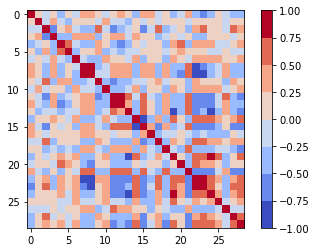

In [44]:
cmap = plt.get_cmap('coolwarm', 8)
plt.imshow(df_task1.corr(), cmap=cmap, vmin=-1, vmax=1)
plt.colorbar()

plt.show()

In [45]:
print('Very strong correlation:\n')
for i in np.arange(df_task1.shape[1]):
    for j in np.arange(i+1,df_task1.shape[1]):
        if abs(df_task1.corr().iloc[i,j]) > 0.75: 
            print('{:32}| {:32}   : corr {:5.2f}'.format(
                df_task1.columns[i], df_task1.columns[j], df_task1.corr().iloc[i,j]))

Very strong correlation:

Income quintile share ratio     | Risk of poverty rate               : corr  0.87
Income quintile share ratio     | Participation in tourism rate      : corr -0.76
Risk of poverty rate            | Participation in tourism rate      : corr -0.82
Risk of poverty rate            | Internet access rate               : corr -0.76
Bad health                      | Very bad health                    : corr  0.83
Household owner rate            | Rail passengers/inh                : corr -0.78
Household owner rate            | Patents/mio inh                    : corr -0.83
Single household rate           | Young adults living with parents   : corr -0.81
Rail passengers/inh             | Patents/mio inh                    : corr  0.81
Participation in tourism rate   | Internet access rate               : corr  0.84


We see that there are as well uncorrelated and correlated feature pairs. I have listed the strongest correlations above. Some of the pairs make a lot of sense intuitively (e.g. "Income quintile share ratio | Risk of poverty rate" or "Single household rate | Young adults living with parents") whereas others are not obvious (e.g. "Rail passengers/inh | Patents/mio inh") and seem to be a bit random.

The targets are the weights of the 12 main product categories in 2015:

In [46]:
df_task1_target = pd.DataFrame(index=df_task1.index, columns=main_cat)
for country in df_task1.index:
    df_task1_target.loc[country,:] = df_inw[(df_inw['Country']==country) & (df_inw['COICOP'].isin(main_cat))]['2015'].values
df_task1_target

,CP01,CP02,CP03,CP04,CP05,CP06,CP07,CP08,CP09,CP10,CP11,CP12
Austria,116.66,38.48,71.85,141.81,76.08,50.8,145.02,21.93,111.77,11.49,142.74,71.36
Belgium,159.85,47.59,57.3,146.49,78.29,71.55,142.09,34.21,91.88,5.5,72.74,92.52
Bulgaria,227.7,71.8,36.15,95.06,67.31,58.4,177.19,60.4,66.02,10.04,79.8,50.13
Croatia,211.36,67.89,49.03,139.79,56.85,49.3,119.84,35.72,91.86,17.4,96.06,64.9
Cyprus,175.07,70.96,64.25,72.56,54.8,60.82,114.17,41.42,64.03,34.17,183.24,64.51
Czechia,178.31,96.92,38.82,177.6,63.48,29.99,110.82,32.37,93.46,6.99,99.73,71.52
Denmark,134.25,45.88,52.8,212.6,58.25,34.29,136.14,21.81,122.59,9.36,65.52,106.51
Estonia,204.05,91.57,64.8,148.62,44.51,37.26,128.27,40.9,82.67,12.22,96.53,48.6
Finland,161.02,59.7,57.8,159.57,62.85,56.07,147.75,28.37,116.7,5.32,81.19,63.66
France,165.91,40.91,50.54,159.62,63.82,42.34,162.4,28.66,86.87,4.57,87.69,106.66


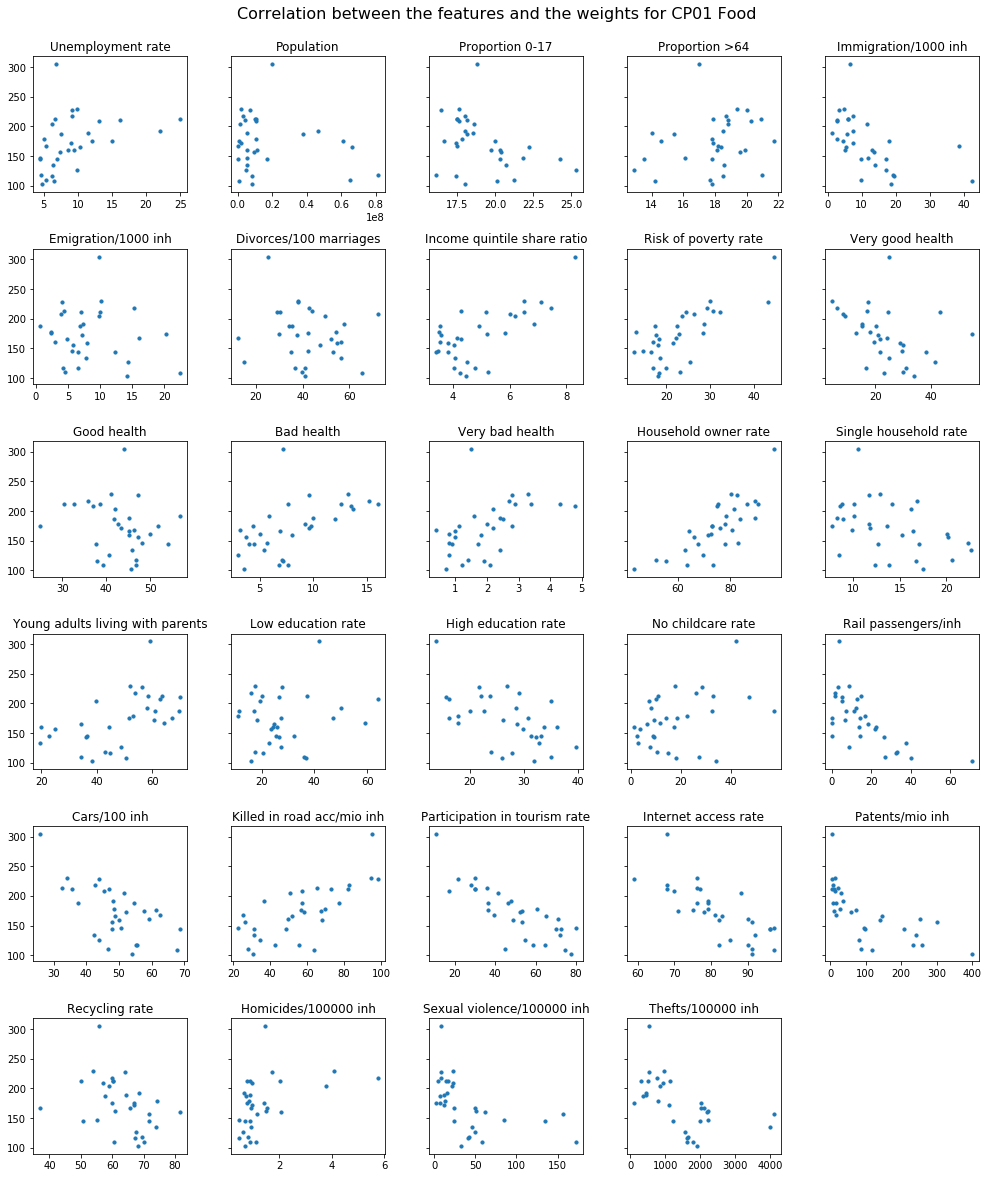

In [47]:
fig, axes = plt.subplots(6,5, figsize=(14,16), sharey=True)

for ax,i in zip(axes.ravel(), np.arange(df_task1.shape[1])):
    ax.scatter(df_task1.iloc[:,i],df_task1_target.iloc[:,0], s=10)
    ax.set_title(df_task1.columns[i])
plt.suptitle('Correlation between the features and the weights for CP01 Food', fontsize=16, y=1.02)
plt.tight_layout()
plt.delaxes(axes[5][4])
plt.show()

Above I have plotted one-by-one all features against the first target, i.e. the weight of food for all countries. In some cases we might distinguish a positive or negative correlation. But there are too many variables to get a clear overview and to draw a conclusion. That is why I want to make use of machine learning to get deeper and more systematic insights.

**Step 2: Principal Component Analysis**

The first step is to use PCA to find out how much variance I really have in my features. Currently my number of features (29) is almost the same as the number of samples (31). I need to reduce the number of features significantly if I do not want to create overfitting models.

After standardizing the features and fitting the PCA, I want to look manually at the components and try to sort out what they mean in plain English: are they rather parallel to my features or are they a linear combination (and of what?). Then my plan is to make a scree plot of all principal components. So I can see how much "independent" variance I have in my features and how many components I need in order to explain 80%, 90%, 95% of the total variance. Also I would like to make a biplot of the two most important components together with some important indicators similar to the one from the course.

From a mathematical point of view it would be the best to continue the project with these most important principal components. But unfortunately they have no physical meaning and cannot tell a story. That is why I prefer to use the insights only as an inspiration and to pick out manually a maximum of five important features ideally from my original set of features (or simple combinations therefrom) and save them to a new dataframe `df_task1_reduced`. Some of the subsequent tasks will be based on that reduced dataframe.

Remember that the PCA is an unsupervised machine learning technique that focusses only on the features but not on the targets. For the latter we need other methods.

**Step 3: Linear Regression**

If all features are scaled to the same range, the coefficients of a fitted linear regression tell us about the importance of that particular feature.

That means that the primary goal is not to learn an optimal model but to use machine learning to judge about feature importance. Here the sample set (i.e. the number of countries) is rather small with only 31 entries. That is why I will refrain from subdividing this set further into train, valiation and test set and will use all available data for training the model.

We have met various linear regression models with different cost functions and without or with regularization in the course:
- Linear Regression
- Huber Regressor
- Ridge Regression
- Lasso Regression

Almost all of them are able to deal with multi-target problems (exception: Huber regressor) but I think it is more intuitive to repeat the task for every target separately, i.e. `y = df_task1_target['CPxx']` for all CPxx. Moreover, due to the limited number of samples which is only slightly higher than the number of features, we have to restrict our model to the reduced dataframe of features, i.e. `X = df_task1_reduced`. So in the end all of the models will give us an idea how much each feature matters to each target. Thereby it is necessary to tune the $\alpha$ parameter of Ridge and Lasso regression by grid search. For comparison it always makes sense to evaluate the accuracy on the train set (=the total set) as MAE.

**Step 4: Decision Tree Regressor and Random Forest Regressor**

A decision tree is a completely different way of judging about the importance of features. It gives a very intuitive and even graphical overview of the "hierarchical structure" of feature importance. Internally it computes the `feature_importances_` property to build up that tree which can be used as an additional numerical output. 

As long as the depth of the decision tree is not too deep this model cannot overfit the dataset. So we can use the full `X = df_task1`. Similar to most of the linear models the decision tree regressor is also able to deal with multi-target outputs but again I prefer to treat every target one-by-one. 

The random forest regressor is very similar as it is constructed as an ensemble of decision trees. I want to repeat the previous steps and see what I get.

**Step 5: Feature permutation in kNN Regressor**

When preparing the proposal I have read about the `sklearn.inspection.permutation_importance` which is only available from scikit-learn version 0.22 onward. However I liked this simple idea and it inspired me to do something similar by hand.

This time I will work on the reduced dataframe `X = df_task1_reduced` because collinear and thus redundant features may disturb the performance of the permutation method. The data needs to be standardized as kNN is working with distance metrics. Again I want to loop over the targets one-by-one.

I will fit a `KNeighborsRegressor` with default parameters to the dataset and evaluate its accuracy. There is no use in optimizing the parameters as kNN could even provide perfect fits on the train set. Then I will create an outer loop over all features. For each feature I will shuffle the values five times, compute the accuracy and finally save the mean accuracy. In general these mean accuracies of the shuffled features will be lower than the accuracy of the original dataset - and the lower they are, the more important is that particular feature.

**Machine Learning Task 2:**

In order to save computing power and without limitation of generality, let's restrict the study to five (?) countries and four (?) main categories that show quite different patterns: 
- Switzerland, Germany, United Kingdom, Romania, Turkey
- 01 Food, 03 Clothing, 08 Communication, 10 Education
   

In [48]:
df_task2 = df_midx[(df_midx['Country'].isin(['Switzerland', 'Germany', 'United Kingdom', 'Romania', 'Turkey'])) 
                   & (df_midx['COICOP'].isin(['CP01','CP03','CP08','CP10']))]
df_task2

,COICOP,Country,2021M06,2021M05,2021M04,2021M03,2021M02,2021M01,2020M12,2020M11,...,1996M10,1996M09,1996M08,1996M07,1996M06,1996M05,1996M04,1996M03,1996M02,1996M01
7555,CP01,Switzerland,101.08,100.86,100.30,100.01,100.35,100.45,100.64,101.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7558,CP01,Germany,113.10,113.40,113.80,112.40,112.40,111.60,108.80,109.20,...,75.00,75.30,75.90,76.70,76.80,76.80,77.00,76.70,76.30,75.70
7586,CP01,Romania,118.62,118.42,116.96,116.46,116.00,115.47,114.69,114.35,...,5.71,5.51,5.39,5.29,5.02,4.99,4.66,4.54,4.48,4.39
7591,CP01,Turkey,226.64,224.70,224.08,219.42,216.92,211.51,206.42,201.33,...,1.78,1.67,1.61,1.53,1.56,1.57,1.50,1.40,1.29,1.24
7592,CP01,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.10,...,65.10,65.70,66.40,65.60,66.50,66.60,66.10,66.10,65.60,64.90
11008,CP03,Switzerland,110.42,112.49,112.02,109.98,105.27,102.94,110.30,112.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11011,CP03,Germany,106.20,105.80,104.60,104.80,103.50,102.10,100.90,105.50,...,92.40,92.20,92.00,91.90,92.00,92.10,92.00,91.90,91.90,91.80
11039,CP03,Romania,114.81,114.59,114.20,114.00,113.89,113.78,113.57,113.39,...,6.29,6.10,5.94,5.59,5.43,5.34,5.27,5.19,5.13,5.06
11044,CP03,Turkey,163.54,159.71,156.93,145.89,143.43,144.77,151.39,156.37,...,3.47,2.95,2.76,2.77,2.85,2.74,2.50,2.14,2.13,2.17
11045,CP03,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.10,...,199.60,199.40,190.20,188.00,198.60,198.60,197.90,197.20,194.90,194.50


In [49]:
# Columns with missing values
df_task2.columns[df_task2.isna().any()]

Index(['2021M06', '2021M05', '2021M04', '2021M03', '2021M02', '2021M01',
       '2020M12', '2004M11', '2004M10', '2004M09',
       ...
       '1996M10', '1996M09', '1996M08', '1996M07', '1996M06', '1996M05',
       '1996M04', '1996M03', '1996M02', '1996M01'],
      dtype='object', length=114)

There are no missing values in the years 2005-2019 so that we can work on these years without restrictions:

In [50]:
# Restrict dataframe, check its shape
df_task2 = df_task2.iloc[:,np.concatenate(([True,True], (df_midx_dates.year > 2004) & (df_midx_dates.year < 2020)))]
df_task2.shape

(20, 182)

Now let's define the different steps to work on:

**Step 1: Recursive prediction of each time series individually** 

>For every (i.e. 4*5 = 20) stand-alone time series, predict all months (i.e. 12) of year 2019 out of years 2005-2018:
>- Always implement a loop over all time series.
>- Inside each loop, create a dataframe with the original time series (=target) and 12 additional time-lagged series (=features). If needed, scale the data. Define 2018 as validation set and 2019 as the test set.
>- Train a separate model for each time series, optimize its parameters and validate it. Compute predictions for the test set.
>- Evaluate the total accuracy for all test set predictions and inspect visually some examples.
>- Repeat the task for several type of models and compare.
    
Below is a schematic overview of how such a dataframe will look like (for only four years). We see the target as well as the 12 time-lagged features. The first 12 rows (in red) are incomplete and cannot be used for machine learning. The next rows (in green) are the actual training and validation data on which the model is going to be built on. The blue values are the 12 monthly values of the year we want to predict and have to be treated as unknown/unseen data. 

The special problem about time-series prediction is that those unknown values are also found on the features' side, in combination with the known yellow values. That is why we have to advance row-by-row: The first unknown value can be predicted as usual out of the known values, and then it can be fed to the features' side. Thus the second value can be predicted as usual, and so on until all values are predicted.

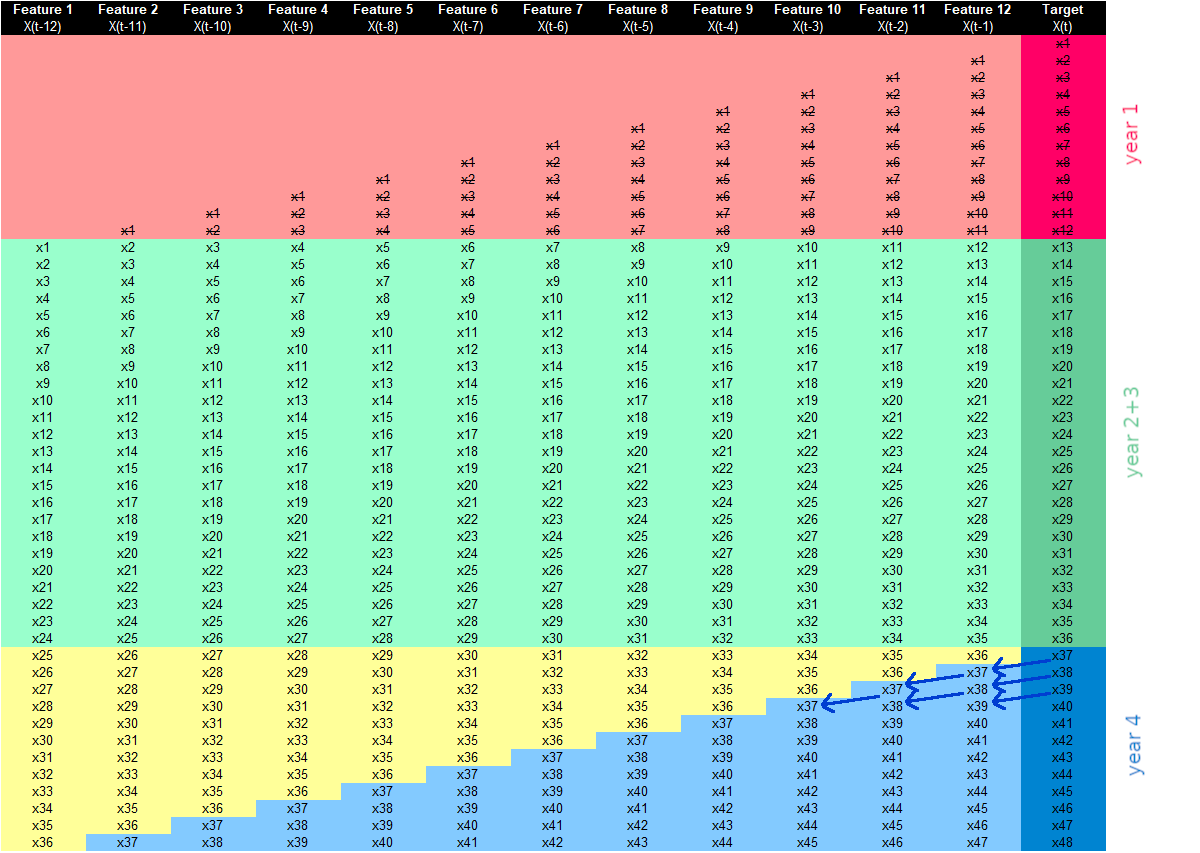

**Step 2: One-step multi-output prediction of each time series individually** 

The question remains the same but another approach will be used for the solution:

>For every (i.e. 4*5 = 20) stand-alone time series, predict all months (i.e. 12) of year 2019 out of years 2005-2018:
>- Always implement a loop over all time series.
>- Inside each loop, re-use the dataframe from step 1 and add 11 targets that are time-lagged in the opposite way. Thus there are 12 features (= a year) and 12 targets (= a year).
>- Train a separate model for each time series, optimize its parameters and validate it. Compute predictions for the test set.
>- Evaluate the total accuracy for all test set predictions and inspect visually some examples.
>- Repeat the task for several type of models and compare.
    
Below is a schematic overview of how such a dataframe will look like (again for only four years). We see the 12 targets as well as the 12 features. The first 12 rows (in red) are incomplete and cannot be used for machine learning. The next rows (in green) are the actual training and validation data on which the model is going to be built on. The blue values are the 12 monthly values of the year we want to predict and have to be treated as unknown/unseen data. 

This time the challenge is that there are rows with known (green) and unknown (blue) values as targets. They can neither be used for learning nor for testing and have to be deleted from the dataframe. The model will only be built on the fully green rows (train+validate). Therefrom we can compute the test set predictions out of the known yellow values.

The fact that we have 12 targets instead of one is no limiting factor. We can think of it as being 12 separate models for Target 1, Target 2, Target 3 and so on. Many model libraries from scikit-learn or tensorflow can directly deal with multi-targets. For others (e.g. Support Vector Machines) we can either create a loop or use the `sklearn.multioutput.MultiOutputRegressor`.

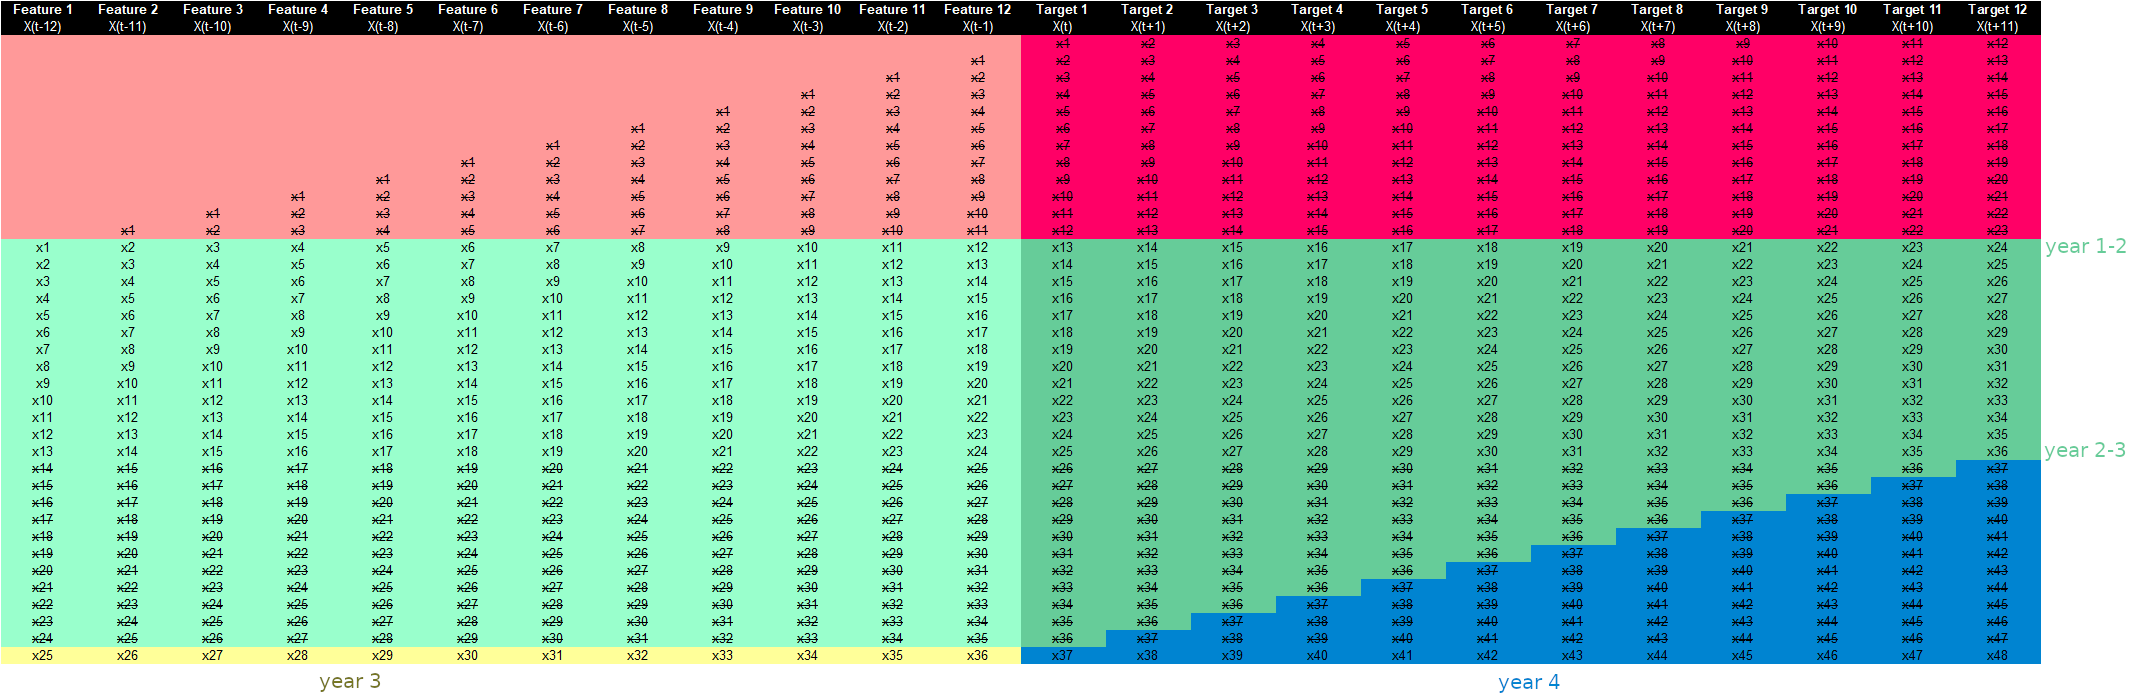

**Step 3: Predict the time series out of the monthly rates of change**

In step 1 and 2 I will work on the original data for the main categories. But in the EDA I will also compute the monthly rates of change for all time series. That will give us another set of time series. Depending on the ML model used it might be much better to use this derived data instead of the original one (because some models restrict their range of predictions to the seen range of values).

So let's choose the more promising approach from step 1 or step 2 and repeat all tasks for the derived time series:

>For each of those 20 time series, predict all months of year 2019 out of years 2005-2018:
>- Perform the same steps as before.
>- Compute the test set predictions for the original data out of the predictions for the monthly rates of change.
>- Evaluate the total accuracy for those predictions.
>- Repeat the task for several type of models and compare.

**Step 4: Prediction of all time series at once**

At that point I will have found out which combinations and setups from steps 1-3 yield a promising approach. All of them have in common that they regard each time series individually and perform an outer loop over them. So as the last study of my project I want to try out if I can get even better results if I build one big model encompassing all time series at once instead of my 20 smaller models.

>For all time series, predict all months of year 2019 out of years 2005-2018 at once:
>- Concatenate the dataframes from the previous setup into a big one. Same for the target. For scikit-learn models that means to add all rows from all dataframes side-by-side, for tensorflow we can go into the third direction.
>- Train a multi-target model and evaluate its accuracy.
>- Repeat the task for several type of models and compare.

## 5) Additional information

I have prepared several dataframes during that proposal that I want to export as .csv for future use:

In [51]:
# df_midx.to_csv('df_midx.csv')
# df_inw.to_csv('df_inw.csv')
# df_midx_flags.to_csv('df_midx_flags.csv')
# df_inw_flags.to_csv('df_inw_flags.csv')

# df_task1.to_csv('df_task1.csv')
# df_task1_target.to_csv('df_task1_target.csv')
# df_task2.to_csv('df_task2.csv')

In [52]:
# Command to read them back into jupyter
# pd.read_csv('df_task1.csv', index_col=0)